# Random Resources to look  into:
[some random dude's btc trader project](https://github.com/lefnire/tforce_btc_trader)

[Open Ai's guide to becoming RL researcher](https://spinningup.openai.com/en/latest/)

[Trading as a game](https://arxiv.org/pdf/1807.02787.pdf)

[A gym like Trading environment ](https://github.com/Kismuz/btgym)

[A tensorflow library for reinforcement learning](https://github.com/reinforceio/tensorforce)

[useful research papers](https://arxiv.org/pdf/1811.07522.pdf)

Reference : https://spinningup.openai.com/en/latest/

* some thoughts on state-of-art algorithms:
    * value-iteration(off-policy) : These don't optimize directly for the expected return but still have good data efficiency.Note: The following don't offer any gaurantees of convergance
       * Deep-q learning and corresponding hacks.
       * Deep Deterministic policy gradient (DDPG)
       * Twin Delayed
       * soft-actor critic
    * On-policy : 
       * Vanilla policy gradient
       * proximal policy optimization(ppo)
       * Trust region policy optimization(trpo)

* A thought on Return: We frequently set up algorithms to optimize the undiscounted return, but use discount factors in estimating value functions.(mathematical conveniance..)



## A taxonomy of useful  RL algorithms (having atleast a basic understandig of these is  useful)

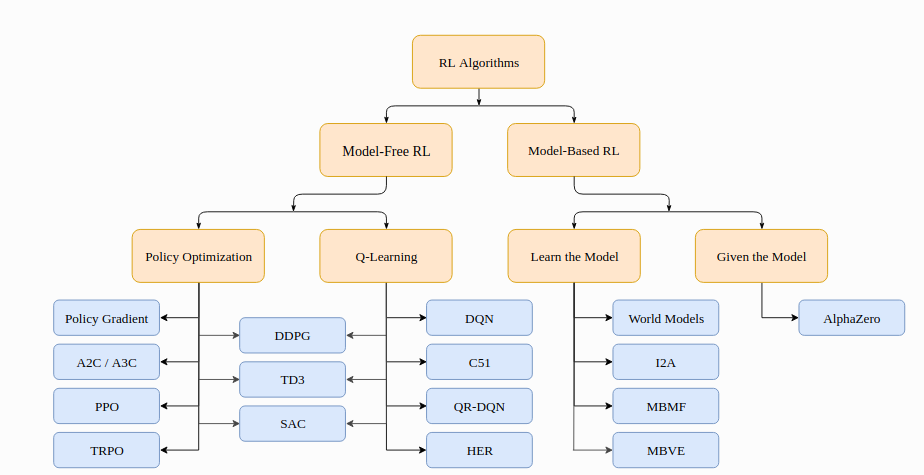

In [1]:

from IPython.display import Image
Image(filename='ataxonomy.png')

## Important thoughts :
* Model free and Model based methods :
    * Though it initially seemed to me a bad idea to consider model based methods for trading...it seems more plausible to have a model of the environment(Note: we are not trying to micro-model the environment but only to an extent needed for prediction)[By model i mean a function which predicts state transitions and rewards.]
    * The main upside to having a model is that it allows the agent to plan by thinking ahead, seeing what would happen for a range of possible choices, and explicitly deciding between its options.Consider how a `master trader` who is consistently making profits in the market...he evolves a model of the environment ..say..observing some patterns correlate to a high probability bet..similar process can be modeled by the agent. Agents can then distill the results from planning ahead into a learned policy. A particularly famous example of this approach is AlphaZero. When this works, it can result in a substantial improvement in sample efficiency over methods that don’t have a model.By the way ,this is an incredably difficult task ... and surely a path to fame.

## The most important section of this notebook : How to get more data for training than there is ?

`Data Augmentation for Model-Free Methods`. Use a model-free RL algorithm to train a policy or Q-function, but either 1) augment real experiences with fictitious ones in updating the agent, or 2) use only fictitous experience for updating the agent.

See (MBVE)[https://arxiv.org/abs/1803.00101] for an example of augmenting real experiences with fictitious ones.
See (World Models)[https://worldmodels.github.io/] for an example of using purely fictitious experience to train the agent, which they call “training in the dream.”

Embedding Planning Loops into Policies. Another approach embeds the planning procedure directly into a policy as a subroutine—so that complete plans become side information for the policy—while training the output of the policy with any standard model-free algorithm. The key concept is that in this framework, the policy can learn to choose how and when to use the plans. This makes model bias less of a problem, because if the model is bad for planning in some states, the policy can simply learn to ignore it.

See (I2A)[https://arxiv.org/abs/1707.06203] for an example of agents being endowed with this style of imagination.


# An intro into Deep Reinforcement Learning(not intended as a study guide but a walk-through of the most promising algorithms with added gotchas for practical implementation..)

In [2]:
"""
A naive algorithm :
1.Play N episodes using a current model(say a random to start with)
2.Collect total reward for all the episodes and decide on a reward boundary say 70th percentile
3.Use these episodes to train the policy...aka neural network
4.Repeat step 1 until satisfied
"""
#Note: There is some bug in the following code.Unlike traditional software engineering....in DL..code fails sailently
    #..the network just don't converge...extra credits if figured out..


from collections import namedtuple
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import gym 
from tensorboardX import SummaryWriter


#define all the variables
HIDDEN_SIZE = 128
BATCH_SIZE = 16
PERCENTILE = 70






class SimpleNet(nn.Module):
    def __init__(self,n_obs,n_hidden,n_action):
        super(SimpleNet,self).__init__()
        self.simplenet = nn.Sequential(
            nn.Linear(n_obs,n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden,n_action)
        )
    def forward(self,input):
        return self.simplenet(input)
    
    
    
    
Episode = namedtuple('Episode', field_names=['reward', 'steps'])
EpisodeStep = namedtuple('EpisodeStep', field_names=['observation', 'action'])
 
sft_max = nn.Softmax(dim = 1)   

def get_action(obs,net):
    """
    Takes observations and the function approximator to return the action to be taken by the agent
    
    """
    obs_tensor = torch.FloatTensor([obs])
    act_probs_tensor = sft_max(net(obs_tensor))
    act_probs = act_probs_tensor.data.numpy()[0]
    return np.random.choice(len(act_probs),p=act_probs)
    
    
    
def get_batches(env,net,batch_size):
    """
    iterates through the environment generating batches of `batch_size` which later get's fed into filter_percentile.
    Input: environment -> env
           Function Approximator -> net
           batch size -> batch_size
    Output:A batch of episodes of given batch_size
    """
    
    batch = [] # A collection of episodes
    init_obs = env.reset() #resets' the environment and gives the initial observation
    episode_reward = 0
    episode_steps = []
    while True:
        action = get_action(init_obs,net)
        next_obs,reward,is_done,_  = env.step(action)
        episode_reward += reward
        episode_steps.append(EpisodeStep(next_obs,action))
        if is_done :
            batch.append(Episode(episode_reward,episode_steps))
            episode_reward = 0.0
            episode_steps = []
            next_obs = env.reset()
            if len(batch) == batch_size:
                yield batch
                batch = []
                
        init_obs = next_obs    
        
def filter_percentile(batch,percentile):
    """
    Takes the batch and returns only top 70 percentile .
    
    """
    rewards = [element.reward for element in batch]
    reward_bound = np.percentile(rewards,percentile)
    reward_mean = float(np.mean(rewards)) #only for logging
    train_obs = []
    train_act = []
    for ele in batch:
        if ele.reward < reward_bound:
            continue
        train_obs.extend([steps.observation for steps in ele.steps])    
        train_act.extend([steps.action for steps in ele.steps])
    
    train_obs_tensor = torch.FloatTensor(train_obs)
    train_act_tensor = torch.LongTensor(train_act)
    return train_obs_tensor, train_act_tensor, reward_bound, reward_mean



    
env = gym.make('CartPole-v0')
env = gym.wrappers.Monitor(env,directory='mon',force = True)
n_obs = env.observation_space.shape[0]
n_action = env.action_space.n
net = SimpleNet(n_obs,HIDDEN_SIZE,n_action)
objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(params = net.parameters(),lr = 0.01)
writer = SummaryWriter(comment = '-cartpole')    
    
    
for iter_no,batch in enumerate(get_batches(env,net,BATCH_SIZE)):
    obs_v,acts_v,reward_b,reward_m = filter_percentile(batch,PERCENTILE)
    optimizer.zero_grad()
    action_scores_v = net(obs_v)
    loss_v = objective(action_scores_v, acts_v)
    loss_v.backward()
    optimizer.step()
    print("%d: loss=%.3f, reward_mean=%.1f, reward_bound=%.1f" % (
            iter_no, loss_v.item(), reward_m, reward_b))
#     writer.add_scalar("loss", loss_v.item(), iter_no)
#     writer.add_scalar("reward_bound", reward_b, iter_no)
#     writer.add_scalar("reward_mean", reward_m, iter_no)
    if reward_m > 199:
        print("Solved!")
        break
    #writer.close()

0: loss=0.684, reward_mean=24.1, reward_bound=23.0
1: loss=0.611, reward_mean=19.9, reward_bound=23.0
2: loss=0.530, reward_mean=14.6, reward_bound=17.5
3: loss=0.491, reward_mean=15.7, reward_bound=16.0
4: loss=0.357, reward_mean=12.4, reward_bound=13.0
5: loss=0.344, reward_mean=12.4, reward_bound=14.0
6: loss=0.189, reward_mean=10.6, reward_bound=12.0
7: loss=0.189, reward_mean=10.5, reward_bound=11.0
8: loss=0.152, reward_mean=10.9, reward_bound=10.0
9: loss=0.087, reward_mean=9.5, reward_bound=10.0
10: loss=0.067, reward_mean=9.9, reward_bound=10.0
11: loss=0.148, reward_mean=10.5, reward_bound=10.0
12: loss=0.048, reward_mean=10.1, reward_bound=10.0
13: loss=0.057, reward_mean=10.4, reward_bound=10.0
14: loss=0.027, reward_mean=9.9, reward_bound=10.0
15: loss=0.029, reward_mean=9.5, reward_bound=10.0
16: loss=0.026, reward_mean=9.6, reward_bound=10.0
17: loss=0.035, reward_mean=10.1, reward_bound=10.0
18: loss=0.033, reward_mean=9.8, reward_bound=10.0
19: loss=0.013, reward_mean=

160: loss=0.000, reward_mean=9.4, reward_bound=10.0
161: loss=0.000, reward_mean=9.1, reward_bound=9.5
162: loss=0.000, reward_mean=9.5, reward_bound=10.0
163: loss=0.000, reward_mean=9.6, reward_bound=10.0
164: loss=0.000, reward_mean=9.2, reward_bound=10.0
165: loss=0.000, reward_mean=9.4, reward_bound=10.0
166: loss=0.000, reward_mean=9.4, reward_bound=10.0
167: loss=0.000, reward_mean=9.2, reward_bound=10.0
168: loss=0.000, reward_mean=9.4, reward_bound=10.0
169: loss=0.000, reward_mean=9.1, reward_bound=9.5
170: loss=0.000, reward_mean=9.5, reward_bound=10.0
171: loss=0.000, reward_mean=9.4, reward_bound=10.0
172: loss=0.000, reward_mean=9.5, reward_bound=10.0
173: loss=0.000, reward_mean=9.4, reward_bound=10.0
174: loss=0.000, reward_mean=9.6, reward_bound=10.0
175: loss=0.000, reward_mean=9.5, reward_bound=10.0
176: loss=0.000, reward_mean=9.6, reward_bound=10.0
177: loss=0.000, reward_mean=9.1, reward_bound=9.0
178: loss=0.000, reward_mean=9.5, reward_bound=10.0
179: loss=0.000

322: loss=0.000, reward_mean=9.4, reward_bound=10.0
323: loss=0.000, reward_mean=9.5, reward_bound=10.0
324: loss=0.000, reward_mean=9.4, reward_bound=10.0
325: loss=0.000, reward_mean=9.6, reward_bound=10.0
326: loss=0.000, reward_mean=9.4, reward_bound=10.0
327: loss=0.000, reward_mean=9.8, reward_bound=10.0
328: loss=0.000, reward_mean=9.4, reward_bound=10.0
329: loss=0.000, reward_mean=9.3, reward_bound=10.0
330: loss=0.000, reward_mean=9.5, reward_bound=10.0
331: loss=0.000, reward_mean=9.1, reward_bound=10.0
332: loss=0.000, reward_mean=9.7, reward_bound=10.0
333: loss=0.000, reward_mean=9.6, reward_bound=10.0
334: loss=0.000, reward_mean=9.2, reward_bound=10.0
335: loss=0.000, reward_mean=9.4, reward_bound=10.0
336: loss=0.000, reward_mean=9.4, reward_bound=10.0
337: loss=0.000, reward_mean=9.1, reward_bound=10.0
338: loss=0.010, reward_mean=9.5, reward_bound=10.0
339: loss=0.000, reward_mean=9.4, reward_bound=10.0
340: loss=0.000, reward_mean=9.6, reward_bound=10.0
341: loss=0.

482: loss=0.000, reward_mean=9.3, reward_bound=9.5
483: loss=0.000, reward_mean=9.1, reward_bound=10.0
484: loss=0.000, reward_mean=9.4, reward_bound=10.0
485: loss=0.000, reward_mean=9.1, reward_bound=9.5
486: loss=0.000, reward_mean=9.4, reward_bound=10.0
487: loss=0.000, reward_mean=9.4, reward_bound=10.0
488: loss=0.000, reward_mean=9.4, reward_bound=10.0
489: loss=0.000, reward_mean=9.2, reward_bound=9.5
490: loss=0.000, reward_mean=9.4, reward_bound=10.0
491: loss=0.000, reward_mean=9.6, reward_bound=10.0
492: loss=0.000, reward_mean=9.0, reward_bound=9.0
493: loss=0.000, reward_mean=9.6, reward_bound=10.0
494: loss=0.000, reward_mean=9.4, reward_bound=10.0
495: loss=0.000, reward_mean=9.6, reward_bound=10.0
496: loss=0.000, reward_mean=9.4, reward_bound=10.0
497: loss=0.000, reward_mean=9.3, reward_bound=10.0
498: loss=0.000, reward_mean=9.6, reward_bound=10.0
499: loss=0.000, reward_mean=9.3, reward_bound=10.0
500: loss=0.000, reward_mean=9.4, reward_bound=10.0
501: loss=0.000,

642: loss=0.000, reward_mean=9.1, reward_bound=10.0
643: loss=0.000, reward_mean=9.1, reward_bound=9.0
644: loss=0.000, reward_mean=9.4, reward_bound=10.0
645: loss=0.000, reward_mean=9.2, reward_bound=10.0
646: loss=0.000, reward_mean=9.5, reward_bound=10.0
647: loss=0.000, reward_mean=9.2, reward_bound=10.0
648: loss=0.000, reward_mean=9.4, reward_bound=10.0
649: loss=0.000, reward_mean=9.4, reward_bound=10.0
650: loss=0.000, reward_mean=9.5, reward_bound=10.0
651: loss=0.000, reward_mean=9.5, reward_bound=10.0
652: loss=0.000, reward_mean=9.4, reward_bound=10.0
653: loss=0.000, reward_mean=9.2, reward_bound=9.0
654: loss=0.000, reward_mean=9.2, reward_bound=10.0
655: loss=0.000, reward_mean=9.2, reward_bound=9.5
656: loss=0.000, reward_mean=9.1, reward_bound=10.0
657: loss=0.000, reward_mean=9.2, reward_bound=9.5
658: loss=0.000, reward_mean=9.3, reward_bound=10.0
659: loss=0.000, reward_mean=9.3, reward_bound=10.0
660: loss=0.000, reward_mean=9.2, reward_bound=9.5
661: loss=0.000, 

804: loss=0.000, reward_mean=9.2, reward_bound=10.0
805: loss=0.000, reward_mean=9.2, reward_bound=10.0
806: loss=0.000, reward_mean=9.6, reward_bound=10.0
807: loss=0.000, reward_mean=9.8, reward_bound=10.0
808: loss=0.000, reward_mean=9.1, reward_bound=10.0
809: loss=0.000, reward_mean=9.3, reward_bound=10.0
810: loss=0.000, reward_mean=9.1, reward_bound=10.0
811: loss=0.000, reward_mean=9.4, reward_bound=10.0
812: loss=0.000, reward_mean=9.4, reward_bound=10.0
813: loss=0.000, reward_mean=9.2, reward_bound=10.0
814: loss=0.000, reward_mean=9.2, reward_bound=10.0
815: loss=0.000, reward_mean=9.3, reward_bound=9.5
816: loss=0.000, reward_mean=9.4, reward_bound=10.0
817: loss=0.000, reward_mean=9.2, reward_bound=10.0
818: loss=0.000, reward_mean=9.2, reward_bound=9.5
819: loss=0.000, reward_mean=9.4, reward_bound=10.0
820: loss=0.000, reward_mean=9.4, reward_bound=10.0
821: loss=0.000, reward_mean=9.5, reward_bound=10.0
822: loss=0.000, reward_mean=9.2, reward_bound=9.5
823: loss=0.000

967: loss=0.000, reward_mean=9.4, reward_bound=10.0
968: loss=0.000, reward_mean=9.5, reward_bound=10.0
969: loss=0.000, reward_mean=9.1, reward_bound=9.0
970: loss=0.000, reward_mean=9.5, reward_bound=10.0
971: loss=0.000, reward_mean=9.3, reward_bound=10.0
972: loss=0.000, reward_mean=9.7, reward_bound=10.0
973: loss=0.000, reward_mean=9.5, reward_bound=10.0
974: loss=0.000, reward_mean=9.7, reward_bound=10.0
975: loss=0.000, reward_mean=9.2, reward_bound=9.5
976: loss=0.000, reward_mean=9.5, reward_bound=10.0


KeyboardInterrupt: 

In [5]:
"""
Tabular Q-learning :
1.Act in the environment
2.Get (s,a,r,s′) from the environment
3.Update using bellmann-equation
4.Check for convergance condition and if not repeat step-2

"""









import gym
import collections
from tensorboardX import SummaryWriter


ENV_NAME = "FrozenLake-v0"
GAMMA = 0.9
ALPHA = 0.2
TEST_EPISODES = 20



class Agent:
    def __init__(self):
        self.env = gym.make(ENV_NAME)
        self.state = self.env.reset()
        self.values = collections.defaultdict(float)

    def sample_env(self):
        action = self.env.action_space.sample()
        old_state = self.state
        new_state, reward, is_done, _ = self.env.step(action)
        self.state = self.env.reset() if is_done else new_state
        return (old_state, action, reward, new_state)

    def best_value_and_action(self, state):
        best_value, best_action = None, None
        for action in range(self.env.action_space.n):
            action_value = self.values[(state, action)]
            if best_value is None or best_value < action_value:
                best_value = action_value
                best_action = action
        return best_value, best_action

    def value_update(self, s, a, r, next_s):
        best_v, _ = self.best_value_and_action(next_s)
        new_val = r + GAMMA * best_v
        old_val = self.values[(s, a)]
        self.values[(s, a)] = old_val * (1-ALPHA) + new_val * ALPHA

    def play_episode(self, env):
        total_reward = 0.0
        state = env.reset()
        while True:
            _, action = self.best_value_and_action(state)
            new_state, reward, is_done, _ = env.step(action)
            total_reward += reward
            if is_done:
                break
            state = new_state
        return total_reward

In [6]:
    test_env = gym.make(ENV_NAME)
    agent = Agent()
    writer = SummaryWriter(comment="-q-learning")

    iter_no = 0
    best_reward = 0.0
    while True:
        iter_no += 1
        s, a, r, next_s = agent.sample_env()
        agent.value_update(s, a, r, next_s)

        reward = 0.0
        for _ in range(TEST_EPISODES):
            reward += agent.play_episode(test_env)
        reward /= TEST_EPISODES
        writer.add_scalar("reward", reward, iter_no)
        if reward > best_reward:
            print("Best reward updated %.3f -> %.3f" % (best_reward, reward))
            best_reward = reward
        if reward > 0.80:
            print("Solved in %d iterations!" % iter_no)
            break
    writer.close()

Best reward updated 0.000 -> 0.150
Best reward updated 0.150 -> 0.200
Best reward updated 0.200 -> 0.250
Best reward updated 0.250 -> 0.300
Best reward updated 0.300 -> 0.400
Best reward updated 0.400 -> 0.450
Best reward updated 0.450 -> 0.500
Best reward updated 0.500 -> 0.550
Best reward updated 0.550 -> 0.600
Best reward updated 0.600 -> 0.650
Best reward updated 0.650 -> 0.700
Best reward updated 0.700 -> 0.750
Best reward updated 0.750 -> 0.800
Best reward updated 0.800 -> 0.850
Solved in 6771 iterations!


# Deep q learning:

Reference : [Playing atari with deep reinforcemet learning - 2013 Minh](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf)


Deep Q Learning:

1.Take initial action in the environment and collect (s,a,r,s^)

2.Use any function approximator to estimate the quality of action.

3.Update Q = r if the state is terminal else Q = r + gamma*max(Q(s^,a^)).

4.Use sgd/it's variant for optimazation....repeat step 2 until convergance.

# Note: Why the above naive implementation will not work ?(They will be resolved towards the end..)

* One of the fundamental assumption of sgd is data is independent and identically distributed(i.i.d) which isn't the case here.
* Distribution of training data is different from the one generated by optimal policy.
* When using bellmann-equation to update the value of Q(s,a) using Q(s^,a^) ..we only have one step difference between them which makes both Q(s,a) and Q(s^,a^) highly correlated.Also when we are updating the weights ... this also changes our estimate of Q(s^,a^)...i.e we are chasing our tail.
* Markov property(present state isn't the complete statistic of the future...) is one of the key assumption which behind all the classic RL algorithms including Deep Q learning but it often fails in practice.



SO,what to do now ?

* Many tricks have been developed over the years after the initial publication of DQN in 2013...here i will share the best of them and train a network.

In [ ]:
# The wrappers are implemented here : https://github.com/openai/baselines/blob/master/baselines/common/atari_wrapper

# Note: The following is an implementation of deep mind's orginal paper but optimized for this environment along with some changes to the model 
# architecture like adding `batch-norm`.Their orginal impl would take around a day to converge on gtx 1070 ..following hopefully will converge in `few hours`..due to some changes like ..	in 100,000	frames,	epsilon	is	linearly	decayed	to	 0.02 ,	which	correspondsto	the	random	action	taken	in	2%	of	steps.	A	similar	scheme	was	used	in	the original	DeepMind	paper,	but	the	duration	of	decay	was	10	times	longer	(so, epsilon	=	0.02	is	reached	after	a	million	frames)

In [ ]:
# IN THE INTEREST OF TIME THIS IS NOT TRAINED...

import torch
import torch.nn as nn

import numpy as np




def conv_layer(ni, nf, ks=3, stride=1):
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=ks, bias=False, stride=stride, padding=ks//2),
        nn.BatchNorm2d(nf, momentum=0.01),
        nn.LeakyReLU(negative_slope=0.1, inplace=True))





class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()

        self.conv = nn.Sequential(
            conv_layer(input_shape[0],32,ks = 8,stride = 4),
            conv_layer(32,64,ks = 4,stride = 2),
            conv_layer(64,64,ks = 3,stride = 1)
            
        )

        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def _get_conv_out(self, shape):  # A hack to flatten the layer without hard coding ..
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)

# now similar to the above methods we can run any of the atari games on this network but before that let's proceed onto `DeepTrader`.....


# Above i have mentioned couple of reasons why naive implementation of DQN will not work..here i will use all the hacks in one go...

REFER - >  Rainbow:Combining Improvements	in	Deep	Reinforcement	Learning

* ## N-stpes DQN : Unroll the bellmann equation
* ## Double DQN : To deal with DQN overestimation of the values of actions
* ## NOISY NETWORKS : Add noise to the weights to make exploration more efficient
* Reference paper:Noisy	Networks for	Exploration
* ## Prioritized replay buffer : Why uniform sampling from the buffer isn't the best option
   * `NOTE`: The	authors	of	the	paper	questioned	the	uniform	random	sample	policy	and proved	that	by	assigning	priorities	to	buffer	samples,	according	to	training loss	and	sampling	the	buffer	proportional	to	those	priorities,	we	can significantly	improve	convergence	and	the	policy	quality	of	the	DQN.	This method	can	be	seen	as	“train	more	on	data	that	surprises	you”.	The	tricky point	here	is	to	keep	the	balance	of	training	on	an	‘unusual’	sample	and training	on	the	rest	of	the	buffer.	If	we	focus	only	on	a	small	subset	of	the buffer,	we	can	lose	our	i.i.d.	property	and	simply	overfit	on	this	subset.
* ## Dueling DQN : How to improve convergance speed by making our network's architecture closer to problem we are solving
    * `Refer` : Dueling Network	Architectures	for	Deep	Reinforcement	Learning	([8]	Wang	et	al.,2015)
* ## Categorical DQN : How to get distributions over Q values.(This also helps us got confidence bound on our predicted Q values which is very useful in financial setting...)
    * `Refer`:Distributional	Perspective	On	Reinforcement	Learning.
    
    
    
    
* `Complete list of references `:
1.  Matteo	Hessel,	Joseph	Modayil,	Hado	van	Hasselt,	Tom	Schaul,	Georg
Ostrovski,	Will	Dabney,	Dan	Horgan,	Bilal	Piot,	Mohammad	Azar,
David	Silver,	2017,	Rainbow:	Combining	Improvements	in	Deep
Reinforcement	Learning.	arXiv:1710.02298
2.	 Sutton,	R.S.	1988,	Learning	to	Predict	by	the	Methods	of	Temporal
Differences,	Machine	Learning	3(1):9-44
3.	 Hado	Van	Hasselt,	Arthur	Guez,	David	Silver,	2015,	Deep	Reinforcement
Learning	with	Double	Q-Learning.	arXiv:1509.06461v3
4.	 Meire	Fortunato,	Mohammad	Gheshlaghi	Azar,	Bilal	Pilot,	Jacob
Menick,	Ian	Osband,	Alex	Graves,	Vlad	Mnih,	Remi	Munos,	Demis
Hassabis,	Olivier	Pietquin,	Charles	Blundell,	Shane	Legg,	2017,	Noisy
Networks	for	Exploration	arXiv:1706.10295v1
5.	 Marc	Bellemare,	Sriram	Srinivasan,	Georg	Ostrovski,	Tom	Schaus,
David	Saxton,	Remi	Munos	2016,	Unifying	Count-Based	Exploration
and	Intrinsic	Motivation	arXiv:1606.01868v2
6.	 Jarryd	Martin,	Suraj	Narayanan	Sasikumar,	Tom	Everitt,	Marcus	Hutter,
2017,	Count-Based	Exploration	in	Feature	Space	for	Reinforcement
Learning	arXiv:1706.08090
7.	 Tom	Schaul,	John	Quan,	Ioannis	Antonoglou,	David	Silver,	2015,
Prioritized	Experience	Replay	arXiv:1511.05952
8.	 Ziyu	Wang,	Tom	Schaul,	Matteo	Hessel,	Hado	van	Hasselt,	Marc
Lanctot,	Nando	de	Freitas,	2015,	Dueling	Network	Architectures	for
Deep	Reinforcement	Learning	arXiv:1511.06581
9.	 Marc	G.	Bellemare,	Will	Dabney,	Rémi	Munos,	2017,	A	Distributional
Perspective	on	Reinforcement	Learning	arXiv:1707.06887

## Till now we only scratched the surface of Deep Reinforcement Learning.We can have agents that predict probability distribution over actions(policy gradient methods).Some times we need some kind of memory....for example single observation is not enough to make the decision...so might include past `k` observations into the `state`.There is a whole branch of RL dealing with POMDP(PARTIALLY OBSERVABLE DECISION PROCESS).To capture all the variants `DeepTrader` is implemented as heirarchy of classes inspired from `open ai gym` and `fastai`.

### LET'S BUILD A BASELINE FOR OUR DEEP TRADER AGENT :
NOTE : 1. In our state we assume instant order execution at the last bar's `close` price.No slippage.
       2. The episode ends once the agent decides to close the position.
       3.0.1% commission is `assumed` for every executed trade.
OBSERVATION WILL INCLUDE :
    * N past (open,high,low,close,profit/loss from current position,indication of past holding)
Action space :
    * (DO NOTHING,BUY A SHARE,CLOSE THE POSITION.)

In [ ]:
#Refer: train_model_conv.py
#The core library / collection of abstractions to make a trading environment compatible with open ai gym...DeepTrader
#is not included here...

In [6]:
# Here's some training in action ---- screenshots...

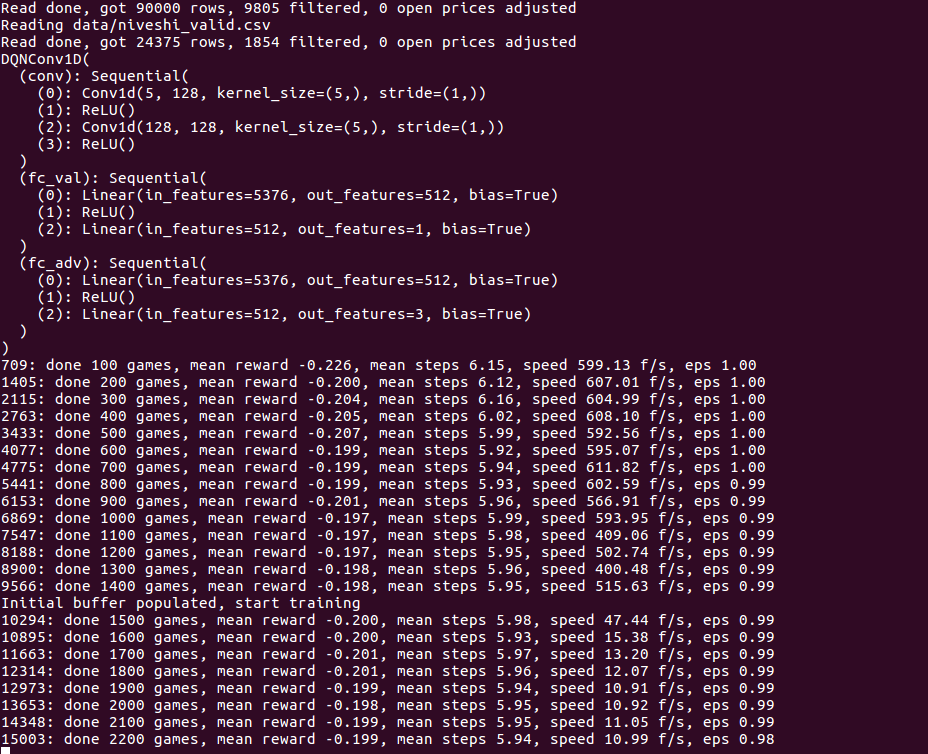

In [2]:
Image('niveshi.png')

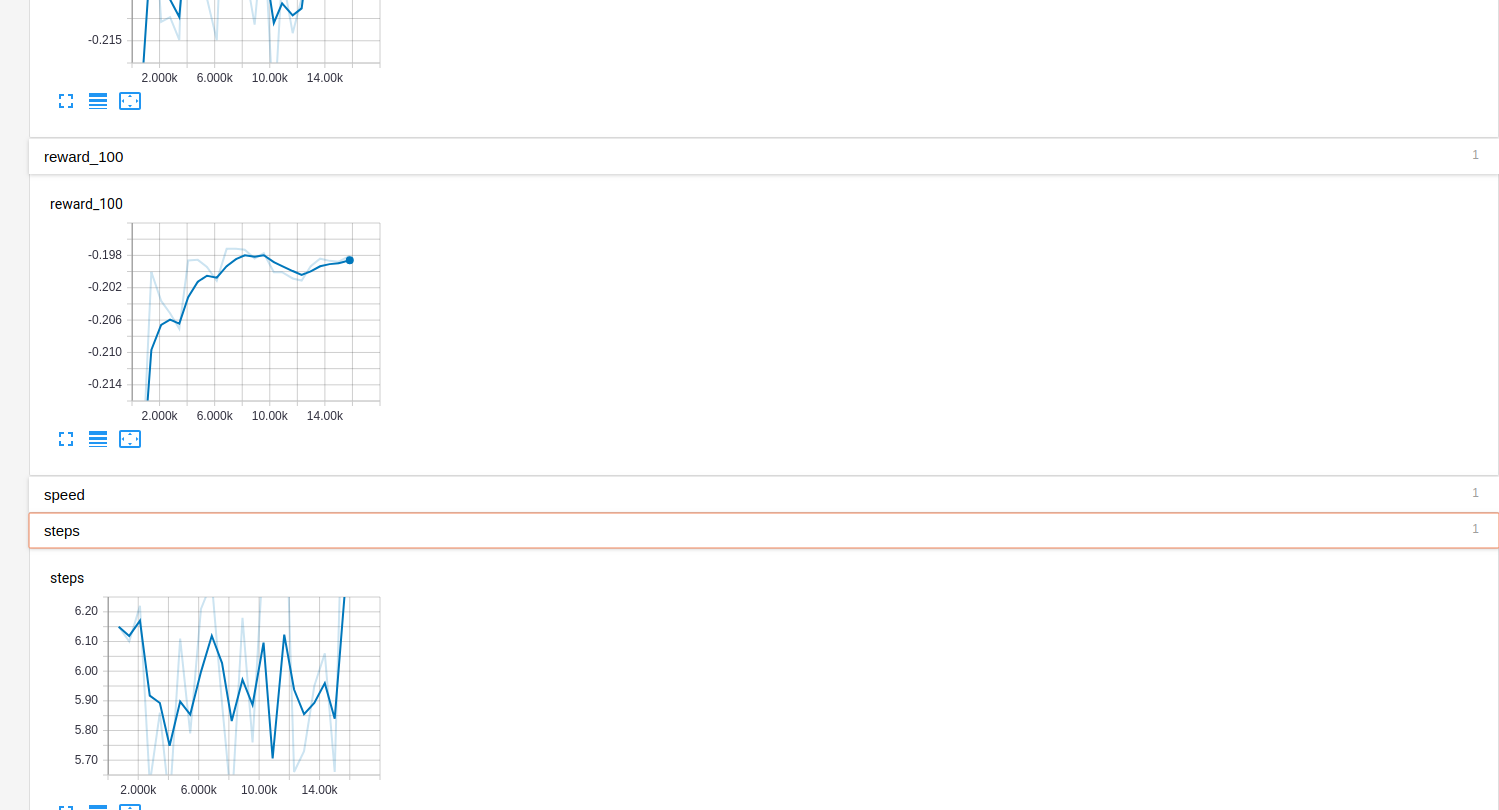

In [3]:
Image('niveshi_tensorflow.png')